In [1]:
import numpy as np
import pandas as pd
import math
from math import e
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
plt.rcParams['font.sans-serif']=['SimHei'] #显示中文
matplotlib.rcParams['axes.unicode_minus']=False

In [2]:
Cell_1_vol_relax = np.load('.\experiment_data\Cell_1_vol_relax.npy'); Cell_2_vol_relax = np.load('.\experiment_data\Cell_2_vol_relax.npy')
Cell_3_vol_relax = np.load('.\experiment_data\Cell_3_vol_relax.npy')

Cell_4_vol_relax = np.load('.\experiment_data\Cell_4_vol_relax.npy'); Cell_5_vol_relax = np.load('.\experiment_data\Cell_5_vol_relax.npy')
Cell_6_vol_relax = np.load('.\experiment_data\Cell_6_vol_relax.npy')

In [3]:
def getT(up, down, nums, minus_1=1): 
    '''
        以等对数间隔采样：对于弛豫电压曲线而言，其随负指数趋势变化，因此通过等对数间隔采样能够尽可能的保证前期变化明显数据的保留
        up:采样值上限  down:采样值下限  nums:采样点数
        minus_1:是否需要在等对数间隔的值上减 ==> 个人理解，求索引值时，因为python从0开始计数，需要减1；求时间常数值时，不需要减1
    '''
    output = []
    length = (np.log(up) - np.log(down)) / (nums-1)
    for i in range(nums):
        if(minus_1):
            output.append(e**(np.log(down)+length*i)-1)
        else:
            output.append(e**(np.log(down)+length*i))
            
    #output = np.array(output)
    
    return output


def resample_lst_10Hz(index, data):
    '''
        依据给出的时间标签值，对原始数据进行重采样
        index:时间标签索引（list输入）， data:待重采样数据（矩阵输入 array）
        由于新补充实验是0.1s采样，因此我们需要对index先进行一定的处理，即每个数*10，并转换为整型，以方便数据重采样
    '''
    index_ = [i * 10 for i in index] ##将时间标签索引*10，变为整数
    index_ = [int(i) for i in index_] ##将整数时间标签索引变为整型
    
    data_resample = np.zeros([data.shape[0], len(index_)])
    for i in range(data.shape[0]):
        lst_i = data[i]
        data_resample[i] = lst_i[index_]
        
    return data_resample

def resample_lst_1Hz(index, data):
    '''
        依据给出的索引值，对原始数据进行重采样
        index:采样索引， data:待重采样数据
    '''
    data_resample = np.zeros([len(data), len(index)])
    for i in range(len(data)):
        lst_i = data[i]
        data_resample[i] = lst_i[index]
        
    return data_resample

#### 获取采样时间索引并对数据进行重采样 ==> U

In [4]:
'''
    获取采样时间序列:
    从3个小时(0.1s采样，共108001个点中等对数间隔取300个数，并对选取的值进行取整、剔除重复值，以得到最终的时间标签[剩余285个时间点])
'''
Time_U_10Hz = np.arange(0, len(Cell_1_vol_relax[0])*0.1, 0.1)  ## 新补充实验中 弛豫电压对应的采样时间标签

time_index_10Hz = getT(up=len(Cell_1_vol_relax[0])*0.1, down=1, nums=300, minus_1=1)  ## 等对数间隔取数据

for i in range(len(time_index_10Hz)):
    time_index_10Hz[i] = round(time_index_10Hz[i], 1)        # 对等对数间隔获取的序列进行取整
time_index_10Hz = list(set(time_index_10Hz))              # set() 去除重复元素，即取整后避免有相同值
time_index_10Hz.sort()

Cell_1_vol_relax_res = resample_lst_10Hz(time_index_10Hz, Cell_1_vol_relax)
Cell_2_vol_relax_res = resample_lst_10Hz(time_index_10Hz, Cell_2_vol_relax)
Cell_3_vol_relax_res = resample_lst_10Hz(time_index_10Hz, Cell_3_vol_relax)

In [5]:
'''
    获取采样时间序列:
    从3个小时(1s采样，共10800个点中等对数间隔取300个数，并对选取的值进行取整、剔除重复值，以得到最终的时间标签)
'''
Time_U_1Hz = np.arange(0, len(Cell_4_vol_relax[0]), 1)  ## 弛豫电压对应的采样时间标签

time_index_1Hz = getT(up=len(Cell_4_vol_relax[0]), down=1, nums=300, minus_1=1)   
for i in range(len(time_index_1Hz)):
    time_index_1Hz[i] = round(time_index_1Hz[i])        # 对等对数间隔获取的序列进行取整
time_index_1Hz = list(set(time_index_1Hz))              # set() 去除重复元素，即取整后避免有相同值
time_index_1Hz.sort()

Cell_4_vol_relax_res = resample_lst_1Hz(time_index_1Hz, Cell_4_vol_relax)
Cell_5_vol_relax_res = resample_lst_1Hz(time_index_1Hz, Cell_5_vol_relax)
Cell_6_vol_relax_res = resample_lst_1Hz(time_index_1Hz, Cell_6_vol_relax)

#### 基于等对数间隔采样获取时间常数序列，并计算系数矩阵  ==> B

In [6]:
tau = getT(up=3600, down=1, nums=200, minus_1=0)

B_10Hz = np.ones([len(time_index_10Hz), len(tau)+1])  # 系数矩阵
for i in range(B_10Hz.shape[0]):
    for j in range(1, B_10Hz.shape[1]):
        B_10Hz[i, j] = e**(-time_index_10Hz[i]/tau[j-1])
        

B_all_10Hz = np.ones([len(Time_U_10Hz), len(tau)+1])
for i in range(B_all_10Hz.shape[0]):
    for j in range(1, B_all_10Hz.shape[1]):
        B_all_10Hz[i, j] = e**(-Time_U_10Hz[i]/tau[j-1])

In [7]:
B_1Hz = np.ones([len(time_index_1Hz), len(tau)+1])  # 系数矩阵
for i in range(B_1Hz.shape[0]):
    for j in range(1, B_1Hz.shape[1]):
        B_1Hz[i, j] = e**(-time_index_1Hz[i]/tau[j-1])
        
B_all_1Hz = np.ones([len(Time_U_1Hz), len(tau)+1])  # 系数矩阵
for i in range(B_all_1Hz.shape[0]):
    for j in range(1, B_all_1Hz.shape[1]):
        B_all_1Hz[i, j] = e**(-i/tau[j-1])

#### 初始化极化电压向量 ==> X

In [8]:
X0 = np.ones(1+len(tau))*4  # *4的原因是开路电压值大约在3~4V
for i in range(1, len(X0)):
    X0[i] = X0[i] * 1e-4  # 初始化各时间常数下的极化电压

#### 基于最小二乘法获取不同周期下的弛豫电压分布情况

In [9]:
def fitness_func(args):
    '''
        最小二乘法中的误差函数
        X:极化电压序列；B:时间常数矩阵；U:端电压序列
        U = B · X ==> 最小二乘优化 min || B·X-U||^2
        U: n*1 ; B: n*(m+1) ; X: (m+1)*1  其中n为采样数量，m为时间常数的数量
    '''
    B, U = args
    loss = lambda X:(B.dot(X)-U).dot((B.dot(X)-U))
    return loss

def get_polarV(U, B, X):
    '''
        通过最小二乘法获取不同周期下极化电压序列
        U:端电压矩阵; B:系数矩阵; X:极化电压初始值
    '''
    polar_V = np.zeros([U.shape[0], B.shape[1]-1])  # 定义极化电压矩阵，用来存储不同周期下的极化电压情况
    X_array = np.zeros([U.shape[0], B.shape[1]])
    
    for i in range(U.shape[0]):
        args = (B, U[i])
        res = minimize(fitness_func(args), X, method='SLSQP', constraints=({'type':'ineq','fun':lambda x:x}))
#         res = minimize(fitness_func(args), X, method='SLSQP')
        polar_V[i] = res.x[1:]
        X_array[i] = res.x
                
    return polar_V, X_array

In [10]:
Cell_1_polar_V, Cell_1_X = get_polarV(Cell_1_vol_relax_res, B_10Hz, X0)
Cell_2_polar_V, Cell_2_X = get_polarV(Cell_2_vol_relax_res, B_10Hz, X0)
Cell_3_polar_V, Cell_3_X = get_polarV(Cell_3_vol_relax_res, B_10Hz, X0)

Cell_4_polar_V, Cell_4_X = get_polarV(Cell_4_vol_relax_res, B_1Hz, X0)
Cell_5_polar_V, Cell_5_X = get_polarV(Cell_5_vol_relax_res, B_1Hz, X0)
Cell_6_polar_V, Cell_6_X = get_polarV(Cell_6_vol_relax_res, B_1Hz, X0)

In [ ]:
'''
这个对话框主要是用于保存不同工况下的弛豫电压分布数据，方便其余代码直接读取数据
np.save('filename', a) ==> 保存成.npy文件;    b = np.load('filename.npy') ==> 读取.npy文件
np.savetxt('new_file.csv', csv_arr) ==> 保存成.csv文件;  np.loadtxt('new_file.csv')  ==> 读取.csv文件  

np.save('.\experiment_data\Cell_1_polar_V', Cell_1_polar_V); np.save('.\experiment_data\Cell_2_polar_V', Cell_2_polar_V)
np.save('.\experiment_data\Cell_3_polar_V', Cell_3_polar_V)
np.save('.\experiment_data\Cell_4_polar_V', Cell_4_polar_V); np.save('.\experiment_data\Cell_5_polar_V', Cell_5_polar_V)
np.save('.\experiment_data\Cell_6_polar_V', Cell_6_polar_V)


np.save('.\experiment_data\Cell_1_X', Cell_1_X); np.save('.\experiment_data\Cell_2_X', Cell_2_X)
np.save('.\experiment_data\Cell_3_X', Cell_3_X)
np.save('.\experiment_data\Cell_4_X', Cell_4_X); np.save('.\experiment_data\Cell_5_X', Cell_5_X)
np.save('.\experiment_data\Cell_6_X', Cell_6_X)
'''

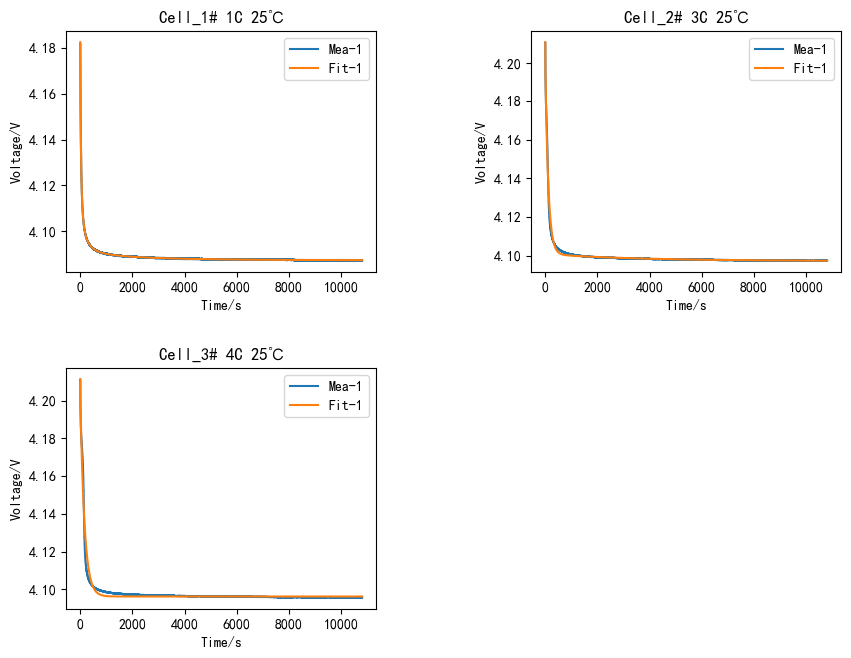

In [11]:
'''
    常温场景下(25℃)的弛豫电压拟合情况
'''
plt.figure(figsize=(10,7.5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.4)

plt.subplot(221)
plt.plot(Time_U_10Hz, Cell_1_vol_relax[0], label='Mea-1')
plt.plot(Time_U_10Hz, np.dot(B_all_10Hz, Cell_1_X[0]), label='Fit-1')
plt.xlabel('Time/s')
plt.ylabel('Voltage/V')
plt.title('Cell_1# 1C 25℃')
plt.legend()

plt.subplot(222)
plt.plot(Time_U_10Hz, Cell_2_vol_relax[0], label='Mea-1')
plt.plot(Time_U_10Hz, np.dot(B_all_10Hz, Cell_2_X[0]), label='Fit-1')
plt.xlabel('Time/s')
plt.ylabel('Voltage/V')
plt.title('Cell_2# 3C 25℃')  
plt.legend()

plt.subplot(223)
plt.plot(Time_U_10Hz, Cell_3_vol_relax[0], label='Mea-1')
plt.plot(Time_U_10Hz, np.dot(B_all_10Hz, Cell_3_X[0]), label='Fit-1')
plt.xlabel('Time/s')
plt.ylabel('Voltage/V')
plt.title('Cell_3# 4C 25℃')
plt.legend()

plt.show()

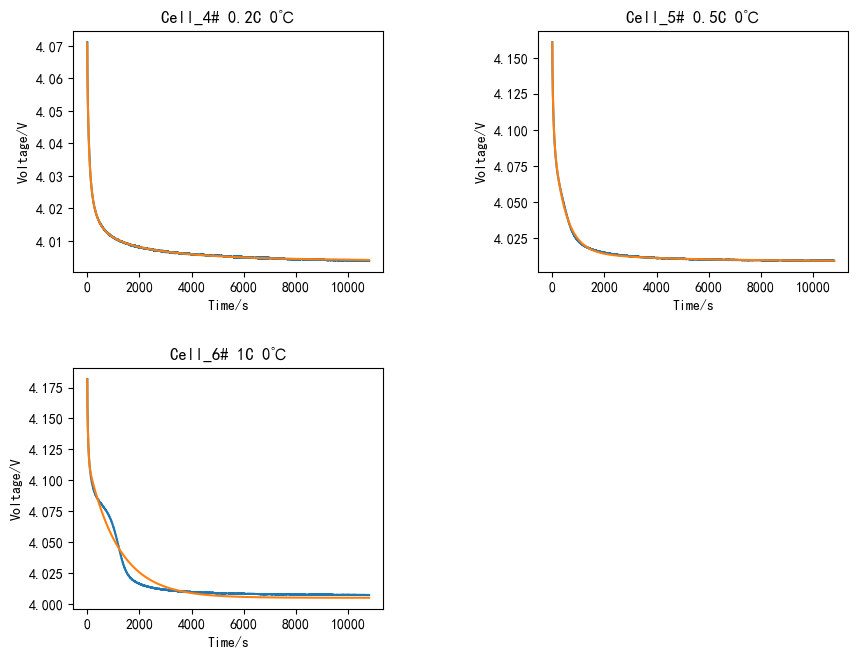

In [12]:
'''
    低温场景下(0℃)的弛豫电压拟合情况
'''
plt.figure(figsize=(10,7.5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.4)

plt.subplot(221)
plt.plot(Time_U_1Hz, Cell_4_vol_relax[0], label='Mea-1')
plt.plot(Time_U_1Hz, np.dot(B_all_1Hz, Cell_4_X[0]), label='Fit-1')
plt.xlabel('Time/s')
plt.ylabel('Voltage/V')
plt.title('Cell_4# 0.2C 0℃')
#plt.legend()

plt.subplot(222)
plt.plot(Time_U_1Hz, Cell_5_vol_relax[0], label='Mea-1')
plt.plot(Time_U_1Hz, np.dot(B_all_1Hz, Cell_5_X[0]), label='Fit-1')
plt.xlabel('Time/s')
plt.ylabel('Voltage/V')
plt.title('Cell_5# 0.5C 0℃')
#plt.legend()

plt.subplot(223)
plt.plot(Time_U_1Hz, Cell_6_vol_relax[0], label='Mea-1')
plt.plot(Time_U_1Hz, np.dot(B_all_1Hz, Cell_6_X[0]), label='Fit-1')
plt.xlabel('Time/s')
plt.ylabel('Voltage/V')
plt.title('Cell_6# 1C 0℃') 
#plt.legend()

plt.show()

In [13]:
def Calculate_Loss(Real, Fit):
    
    RMSE = np.sqrt(np.mean((Real - Fit) ** 2))
    
    MAPE = np.mean(abs(Real-Fit)/Real) 
    
    SST = np.sum((Real-np.mean(Real))**2)
    SSE = np.sum((Real-Fit)**2)
    R2 = 1 - SSE/SST
    
    MSE = np.mean((Real-Fit)**2)
    
    return MAPE

In [14]:
Cell_1_error = np.zeros(Cell_1_polar_V.shape[0]); Cell_2_error = np.zeros(Cell_2_polar_V.shape[0])
Cell_3_error = np.zeros(Cell_3_polar_V.shape[0])

Cell_4_error = np.zeros(Cell_4_polar_V.shape[0]); Cell_5_error = np.zeros(Cell_5_polar_V.shape[0])
Cell_6_error = np.zeros(Cell_6_polar_V.shape[0])

for i in range(Cell_1_polar_V.shape[0]):
    
    Cell_1_error[i] = Calculate_Loss(Cell_1_vol_relax[i], np.dot(B_all_10Hz, Cell_1_X[i]))
    
for i in range(Cell_2_polar_V.shape[0]):
    
    Cell_2_error[i] = Calculate_Loss(Cell_2_vol_relax[i], np.dot(B_all_10Hz, Cell_2_X[i]))
    
for i in range(Cell_3_polar_V.shape[0]):
    
    Cell_3_error[i] = Calculate_Loss(Cell_3_vol_relax[i], np.dot(B_all_10Hz, Cell_3_X[i]))
    
for i in range(Cell_4_polar_V.shape[0]):
    
    Cell_4_error[i] = Calculate_Loss(Cell_4_vol_relax[i], np.dot(B_all_1Hz, Cell_4_X[i]))
    
for i in range(Cell_5_polar_V.shape[0]):
    
    Cell_5_error[i] = Calculate_Loss(Cell_5_vol_relax[i], np.dot(B_all_1Hz, Cell_5_X[i]))
    
for i in range(Cell_6_polar_V.shape[0]):
    
    Cell_6_error[i] = Calculate_Loss(Cell_6_vol_relax[i], np.dot(B_all_1Hz, Cell_6_X[i]))

KstestResult(statistic=0.1246010513627509, pvalue=0.1531464175687116) 1.7429249557445027e-05 2.3992535742579855e-06


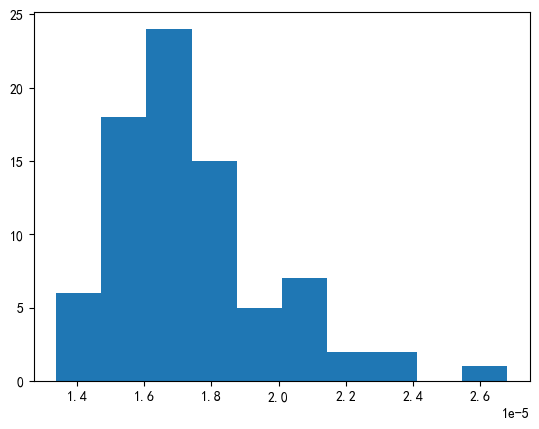

In [15]:
from scipy.stats import kstest

Reference_Cell_error = np.concatenate((Cell_1_error, Cell_4_error))

mean = np.mean(Reference_Cell_error); std = np.std(Reference_Cell_error);
test_stat = kstest(Reference_Cell_error, 'norm', (mean, std))
print(test_stat, mean, std)

plt.hist(Reference_Cell_error, 10)
plt.show()

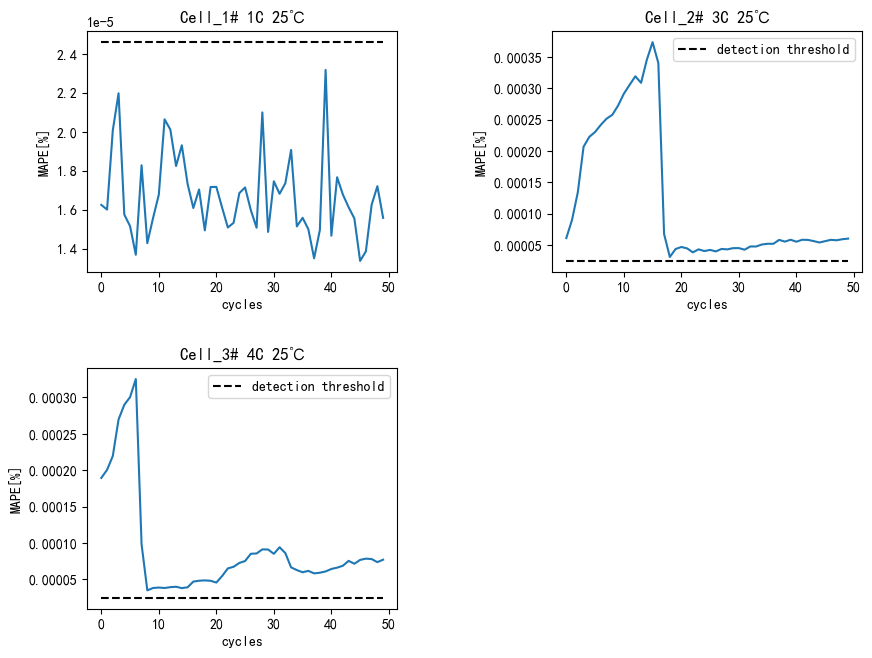

In [16]:
threshold_3sigma = mean + 3*std

plt.figure(figsize=(10,7.5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.4)

plt.subplot(221)
error_3sigma = np.ones(len(Cell_1_error))*threshold_3sigma
plt.plot(Cell_1_error)
plt.plot(error_3sigma,'--',c='black', label='detection threshold')
plt.xlabel('cycles')
plt.ylabel('MAPE[%]')
plt.title('Cell_1# 1C 25℃')
#plt.legend()

plt.subplot(222)
error_3sigma = np.ones(len(Cell_2_error))*threshold_3sigma
plt.plot(Cell_2_error)
plt.plot(error_3sigma,'--',c='black', label='detection threshold')
plt.xlabel('cycles')
plt.ylabel('MAPE[%]')
plt.title('Cell_2# 3C 25℃') 
plt.legend()

plt.subplot(223)
error_3sigma = np.ones(len(Cell_3_error))*threshold_3sigma
plt.plot(Cell_3_error)
plt.plot(error_3sigma,'--',c='black', label='detection threshold')
plt.xlabel('cycles')
plt.ylabel('MAPE[%]')
plt.title('Cell_3# 4C 25℃')
plt.legend()

plt.show()

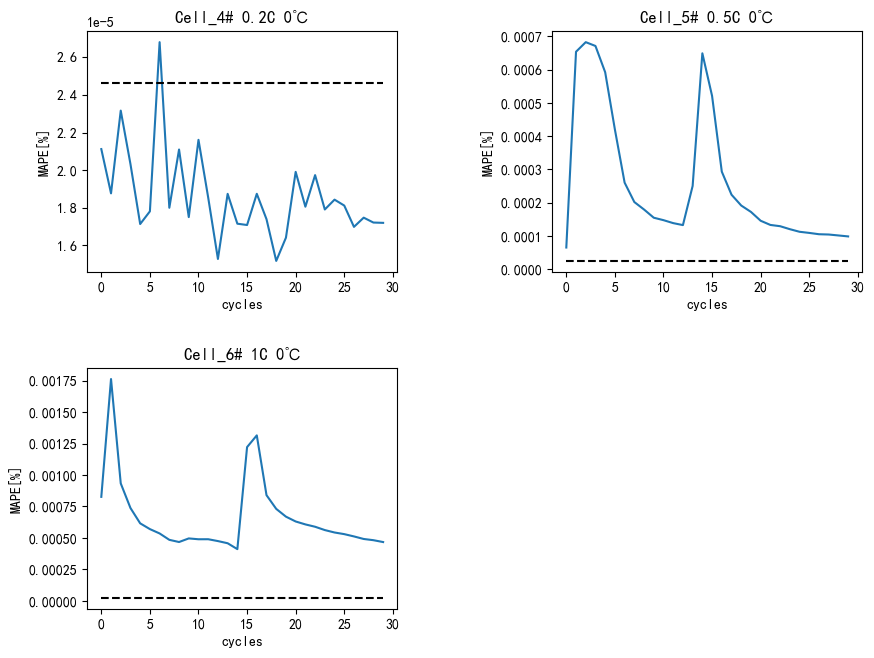

In [30]:
plt.figure(figsize=(10,7.5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.4)

plt.subplot(221)
error_3sigma = np.ones(len(Cell_4_error))*threshold_3sigma
plt.plot(Cell_4_error)
plt.plot(error_3sigma,'--',c='black', label='detection threshold')
plt.xlabel('cycles')
plt.ylabel('MAPE[%]')
plt.title('Cell_4# 0.2C 0℃')

plt.subplot(222)
error_3sigma = np.ones(len(Cell_5_error))*threshold_3sigma
plt.plot(Cell_5_error)
plt.plot(error_3sigma,'--',c='black', label='detection threshold')
plt.xlabel('cycles')
plt.ylabel('MAPE[%]')
plt.title('Cell_5# 0.5C 0℃')

plt.subplot(223)
error_3sigma = np.ones(len(Cell_6_error))*threshold_3sigma
plt.plot(Cell_6_error)
plt.plot(error_3sigma,'--',c='black', label='detection threshold')
plt.xlabel('cycles')
plt.ylabel('MAPE[%]')
plt.title('Cell_6# 1C 0℃')

plt.show()